# Proyecto final - CNN

En este cuadreno se explorará el uso de redes neuronales convolusionales para el conjunto de datos PVQM (Perceptual visual quality metrics).

Como primer paso se importan las bibliotecas necesarias.

In [7]:
import os
import numpy as np
import pandas as pd
import random
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import Sequence
from keras import backend as k
from keras.models import model_from_json
from sklearn.model_selection import train_test_split

## Conjunto de datos

Dado que en conjunto de datos de imágenes es de alrededor de los 15300, las cuales cada una de ellas son RBG y de una dimension de 512x384; representa una cantidad inmensa para ser cargadas a la vez en la memoria.

Es por ello que Keras cuenta con los Data Generators, donde se va inyectando al modelo los datos en batches. La siguiente clase es un ejemplo de un Data Generator, en la cual podemos definir cuales son los cojuntos de datos de entrada y salida, el tamaño del batch en que los queremos dividir, sus dimensiones, entre otras variables.

In [8]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        # Set the correct data format
        X = self.__set_data_format(X)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __set_data_format(self, data):
        if k.image_data_format() == 'channels_first':
            data = data.reshape(data.shape[0], self.n_channels, self.dim[0], self.dim[1])
        else:
            data = data.reshape(data.shape[0], self.dim[0], self.dim[1], self.n_channels)
        return data

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open( '/floyd/input/pvqm_db/distorted_images/' + ID )
            X[i,] = np.asarray( img, dtype="float32" )
            X[i,] /=255

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [9]:
def load_image( infilename ) :
    img = Image.open( '/floyd/input/pvqm_db/distorted_images/' + infilename )
    data = np.asarray( img, dtype="int32" )
    return data

Vamos a crear un dictionario llamado **Partition**, que cuenta con dos entradas: **partitions['train']** y **partitions['validation']**; cada uno de estas entradas va a tener una lista con los Strings correspondientes a los nombres de las imágenes a ser cargadas por el Data Generator. Posteriormente vamos a generar un diccionario llamado **lables**, el cual va a mapear los nombres de las imágenes con su correspondiente valor de salida o puntaje.

In [10]:
from os import listdir
from os.path import isfile, join
path = '/floyd/input/pvqm_db/distorted_images'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

# Input image data
img_rows , img_cols = 384, 512
depth = 3

# Load the image data
imageDataset = []
dataIDs = []
index = 0
for imagePath in onlyfiles:
    if index < 5:
        image = load_image(imagePath)
        imageDataset.append(image)
    
    dataIDs.append(imagePath)
    index += 1
imageDataset = np.asarray(imageDataset)

# Load the MOS data
outputFilePath = "mos_std_upd.txt"
mos = pd.read_csv(outputFilePath, sep=" ", header=None)
# Generate label's dictionay
labels = {}
index = 0
for score in mos.values.tolist():
    labels[dataIDs[index]] = score[0]
    index += 1

# Shuffle the data
random.seed(4)
random.shuffle(dataIDs)

# Split the data
frac = 0.7
fracPortion = int(len(dataIDs) * frac)
trainSet = dataIDs[:fracPortion]
testSet = dataIDs[fracPortion:]

# Create the partition dictionary
partition = {}
partition['train'] = trainSet
partition['validation'] = testSet

# Prepare the data generator
params = {'dim': (img_rows,img_cols),
          'batch_size': 8,
          'n_channels': depth,
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

## Exploración de los datos

En esta sección solamente se visualiza algunas de las imágenes del conjunto de datos y sus correspondiente dimensiones para tenerlas como referencia.

(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)


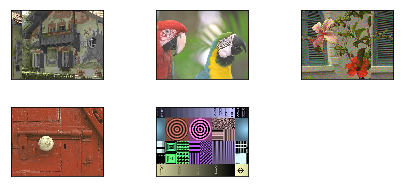

In [5]:
#visualising first 5 data from training dataset

fig = plt.figure()
for i in range(5):
    print(imageDataset[1].shape)
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(imageDataset[i])
    plt.xticks([])
    plt.yticks([])

## Red neuronal CNN

Para el diseñ de la red convolusional, contamos con la función ***create_cnn*** en la cual podemos describir la forma de los datos especificando su alto, ancho, profundidad; así como el número de capas convolusionales y la cantidad de filtros para cada una de estas capas. La segunda parte de la red es una MLP sencilla y tiene un perceptron de salida.

In [6]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="sigmoid")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model



# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  k.sum(k.square( y_true-y_pred )) 
    SS_tot = k.sum(k.square( y_true - k.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + k.epsilon()) )

model = create_cnn(img_cols, img_rows, depth, regress=True)

# load weights
model.load_weights("modelCNN.h5")

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer='adam', metrics=[coeff_determination])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 512, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 384, 512, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 512, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 256, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 192, 256, 32)      0         
__________

## Entrenamiento del modelo

Para el entrenamiento de la CNN, dado que se requiere de buen poder computacional, se utilizón la plataforma **FloydHub**.

Con el fin de evitar inconvenientes en caso de algun error o contratiempo durante el entrenamiento, se hace uso de los checkpoints, los cuales van monitoriando una determinada métrica y guarda los pesos de la red ante una mejora de esta. Esto nos permite tener un respaldo en caso de algun fallo y poder continuar el entrenamiento a partir de ese punto y no desde el inicio.

Se procede a utilizar una cantidad de epochs de 50, el cual tiene una duración de entrenamiento aproximada de 3 horas.

In [7]:
import time

batch_size = 8
num_epoch = 50

filepath="weightsCNN.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='coeff_determination', verbose=1, save_best_only=True, mode='max')

#model training

start = time.time()

model_log = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=3,
                    epochs=num_epoch,
                    callbacks=[checkpoint],
                    verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)

print(f"Training time: {m} min / {s} sec")


Epoch 00001: coeff_determination improved from -inf to -0.17383, saving model to weightsCNN.best.hdf5

Epoch 00002: coeff_determination did not improve from -0.17383

Epoch 00003: coeff_determination did not improve from -0.17383

Epoch 00004: coeff_determination did not improve from -0.17383

Epoch 00005: coeff_determination did not improve from -0.17383

Epoch 00006: coeff_determination did not improve from -0.17383

Epoch 00007: coeff_determination improved from -0.17383 to -0.17194, saving model to weightsCNN.best.hdf5

Epoch 00009: coeff_determination did not improve from -0.15243

Epoch 00010: coeff_determination did not improve from -0.15243

Epoch 00011: coeff_determination improved from -0.15243 to -0.15042, saving model to weightsCNN.best.hdf5

Epoch 00012: coeff_determination did not improve from -0.15042

Epoch 00013: coeff_determination did not improve from -0.15042

Epoch 00014: coeff_determination did not improve from -0.15042

Epoch 00015: coeff_determination improved 

## Evaluación del rendimiento del CNN

En esta sección se evalúa el rendimiento de la red para los conjuntos de entrenamiento y de prueba.

In [11]:
#how well did it do? 

start = time.time()

score = model.evaluate_generator(training_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Train loss:', score[0])
print('Train accuracy:', score[1]*100, '%')

print(f"Train time: {m} min / {s} sec")

Train loss: 0.014809111053562933
Train accuracy: 38.12190231899153 %
Train time: 0.89 min / 53.34 sec


In [12]:
start = time.time()

score = model.evaluate_generator(validation_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

print(f"Test time: {m} min / {s} sec")

Test loss: 0.037404799077702104
Test accuracy: -61.04155519869939 %
Test time: 0.39 min / 23.15 sec


0.7022555470532414


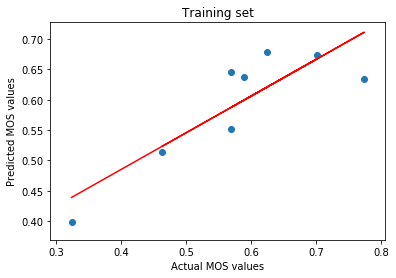

-0.7869378482449243


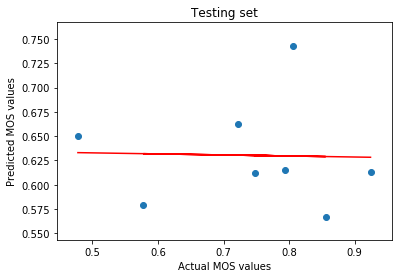

In [13]:
from sklearn.metrics import r2_score

def plot_metric(group, title):
    x_test, y_test = group.__getitem__(0)
    Y_pred = model.predict(x_test)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')
    #plt.text(1, 0.1, 'R-squared = %0.2f' % r_squared)
    print(r_squared)
    plt.show()
    
plot_metric(training_generator, 'Training set')
plot_metric(validation_generator, 'Testing set')

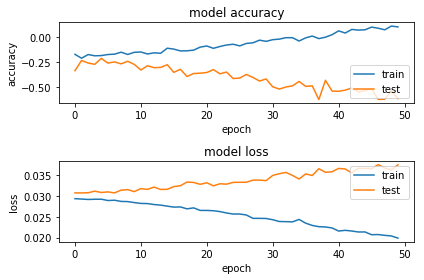

In [14]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['coeff_determination'])
plt.plot(model_log.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

De los resultados anteriores podemos notar claramente un sobreajuste que posee la red. Posibles acciones que se pueden tomar estan el simplificar la red o generar más datos; asi como optimizar los hiperparámetros.

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("modelCNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelCNN.h5")
print("Saved model to disk")

Saved model to disk


## Simplificación de la CNN

A continuación se presenta una arquitectura de CNN más simple que la anterior, donde reducimos el número de capas convolusionales y la cantidad de filtros en cada una de ellas, asi como la reducción del número de perceptrones en las capas de la MLP. Con estas acciones los parametros de la red se reducen considerablemente.

In [11]:
def create_simple_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(4)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(2)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="sigmoid")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  k.sum(k.square( y_true-y_pred )) 
    SS_tot = k.sum(k.square( y_true - k.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + k.epsilon()) )

model = create_simple_cnn(img_cols, img_rows, depth, filters=(4, 8), regress=True)
model.compile(loss="mean_squared_error", optimizer='adam', metrics=[coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 384, 512, 4)       112       
_________________________________________________________________
activation_9 (Activation)    (None, 384, 512, 4)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 384, 512, 4)       16        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 192, 256, 4)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 192, 256, 8)       296       
_________________________________________________________________
activation_10 (Activation)   (None, 192, 256, 8)       0         
__________

Procedemos a un nuevo entrenamientom, pero en este caso con la red CNN simplificada.

In [12]:
import time

batch_size = 8
num_epoch = 50

filepath="weightsSimpleCNN.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='coeff_determination', verbose=1, save_best_only=True, mode='max')

#model training

start = time.time()

model_log = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=3,
                    epochs=num_epoch,
                    callbacks=[checkpoint],
                    verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)

print(f"Training time: {m} min / {s} sec")


Epoch 00001: coeff_determination improved from -inf to -0.33119, saving model to weightsSimpleCNN.best.hdf5

Epoch 00002: coeff_determination improved from -0.33119 to -0.22624, saving model to weightsSimpleCNN.best.hdf5

Epoch 00003: coeff_determination improved from -0.22624 to -0.20578, saving model to weightsSimpleCNN.best.hdf5

Epoch 00004: coeff_determination did not improve from -0.20578

Epoch 00005: coeff_determination improved from -0.20578 to -0.19621, saving model to weightsSimpleCNN.best.hdf5

Epoch 00006: coeff_determination did not improve from -0.19621

Epoch 00007: coeff_determination did not improve from -0.19621

Epoch 00008: coeff_determination improved from -0.19621 to -0.19081, saving model to weightsSimpleCNN.best.hdf5

Epoch 00009: coeff_determination did not improve from -0.19081

Epoch 00010: coeff_determination did not improve from -0.19081

Epoch 00011: coeff_determination did not improve from -0.19081

Epoch 00012: coeff_determination did not improve from 

In [13]:
#how well did it do? 

start = time.time()

score = model.evaluate_generator(training_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Train loss:', score[0])
print('Train accuracy:', score[1]*100, '%')

print(f"Train time: {m} min / {s} sec")

Train loss: 0.016776047546332298
Train accuracy: 31.668716481982862 %
Train time: 0.75 min / 44.78 sec


In [14]:
start = time.time()

score = model.evaluate_generator(validation_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

print(f"Test time: {m} min / {s} sec")

Test loss: 0.03384863048707368
Test accuracy: -40.69710168955006 %
Test time: 0.33 min / 19.53 sec


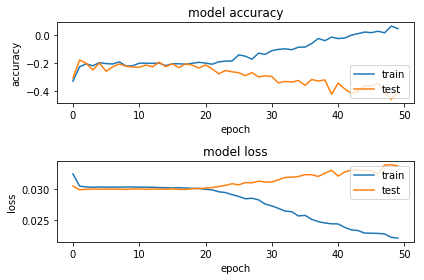

In [15]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['coeff_determination'])
plt.plot(model_log.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

De los resultados obtenidos en este segundo entrenamiento, podemos notar que el rendimiento del conjunto de entrenamiento se disminuye con respecto a la red anterior; esto es esperado dadod que la red es más simple (menos "inteligente"). Además podemos ver que el overfiting sigue presente, aunque en menor medida que en la red anterior.

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("modelSimpleCNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelSimpleCNN.h5")
print("Saved model to disk")

Saved model to disk
